<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week7%20/DeepRNN/ReviewTokoBaju_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


<ipython-input-2-67271d2d12d0>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
# 1. Data Loading and Exploration
print("Loading data...")
df = pd.read_csv('https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv')
print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())


Loading data...
Dataset shape: (23486, 11)

Sample data:
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                      

In [5]:
# 2. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In [7]:
# 3. Data Preprocessing
print("\nPreprocessing data...")

# Create target variable - assuming Recommended IND is our target for sentiment
df['target'] = df['Recommended IND'].astype(int)



Preprocessing data...


In [8]:
# Check class distribution
print("\nClass distribution:")
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))



Class distribution:
target
1    19314
0     4172
Name: count, dtype: int64
target
1    0.822362
0    0.177638
Name: proportion, dtype: float64


In [9]:
# 4. Text Preprocessing and Tokenization
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase and remove extra whitespace
        text = text.lower().strip()
        return text
    return ""

df['processed_text'] = df['Review Text'].apply(preprocess_text)


In [10]:
# Check text length distribution for better padding
text_lengths = df['processed_text'].str.split().str.len()
print(f"\nText length statistics:")
print(f"Mean: {text_lengths.mean()}")
print(f"Median: {text_lengths.median()}")
print(f"95th percentile: {text_lengths.quantile(0.95)}")



Text length statistics:
Mean: 58.030869454142895
Median: 57.0
95th percentile: 101.0


In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target']
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Training set size: 18788
Testing set size: 4698


In [12]:
# Tokenize the text
max_words = 15000  # Maximum number of words to keep
max_len = 150  # Maximum length of reviews (increased from previous model)

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [13]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [14]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [15]:
# Check vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")



Vocabulary size: 13558


In [16]:
# 5. Deep RNN Model Definition
def build_deep_rnn_model(hp=None):
    # Default hyperparameters if not tuning
    embedding_dim = 256 if hp is None else hp.Int('embedding_dim', min_value=128, max_value=512, step=64)
    rnn_units_1 = 128 if hp is None else hp.Int('rnn_units_1', min_value=64, max_value=256, step=64)
    rnn_units_2 = 128 if hp is None else hp.Int('rnn_units_2', min_value=64, max_value=256, step=64)
    rnn_units_3 = 64 if hp is None else hp.Int('rnn_units_3', min_value=32, max_value=128, step=32)
    dropout_rate_1 = 0.4 if hp is None else hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)
    dropout_rate_2 = 0.4 if hp is None else hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)
    dropout_rate_3 = 0.3 if hp is None else hp.Float('dropout_rate_3', min_value=0.2, max_value=0.5, step=0.1)
    dense_units = 64 if hp is None else hp.Int('dense_units', min_value=32, max_value=128, step=32)
    learning_rate = 0.001 if hp is None else hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    rnn_type = 'lstm' if hp is None else hp.Choice('rnn_type', values=['lstm', 'gru'])

    model = Sequential()
    model.add(Embedding(min(vocab_size, max_words), embedding_dim, input_length=max_len))
    model.add(Dropout(dropout_rate_1))

    # First RNN layer
    if rnn_type == 'lstm':
        model.add(LSTM(rnn_units_1, return_sequences=True))
    else:
        model.add(GRU(rnn_units_1, return_sequences=True))
    model.add(Dropout(dropout_rate_1))

    # Second RNN layer
    if rnn_type == 'lstm':
        model.add(LSTM(rnn_units_2, return_sequences=True))
    else:
        model.add(GRU(rnn_units_2, return_sequences=True))
    model.add(Dropout(dropout_rate_2))

    # Third RNN layer
    if rnn_type == 'lstm':
        model.add(LSTM(rnn_units_3))
    else:
        model.add(GRU(rnn_units_3))
    model.add(Dropout(dropout_rate_3))

    # Dense layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate_3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [18]:
# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_deep_rnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [20]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8190 - loss: 0.4791
Epoch 1: val_accuracy did not improve from 0.82970
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8190 - loss: 0.4791 - val_accuracy: 0.8297 - val_loss: 0.4577 - learning_rate: 5.0000e-04
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8190 - loss: 0.4772
Epoch 2: val_accuracy did not improve from 0.82970
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8190 - loss: 0.4771 - val_accuracy: 0.8297 - val_loss: 0.4570 - learning_rate: 5.0000e-04
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8190 - loss: 0.4764
Epoch 3: val_accuracy did not improve from 0.82970
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8190 - loss: 0.4764 - val_accuracy: 0.8297 - val_loss: 0.4572 - learning_rate: 5.0000e-04
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8190 - loss: 0.4777
Epoch 4: val_accuracy did not improve from 0.82970

Epoch 4:

In [22]:
# 7. Model Evaluation
print("\nEvaluating the model...")
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nBasic Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")


Evaluating the model...
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Basic Model Performance:
Accuracy: 0.8223
Precision: 0.8223
Recall: 1.0000
F1 Score: 0.9025
AUC-ROC: 0.5040


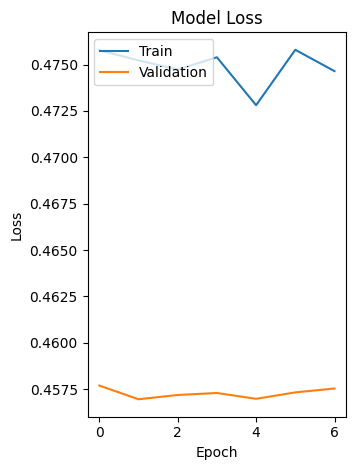

In [24]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('deep_rnn_training_metrics.png')
plt.show()


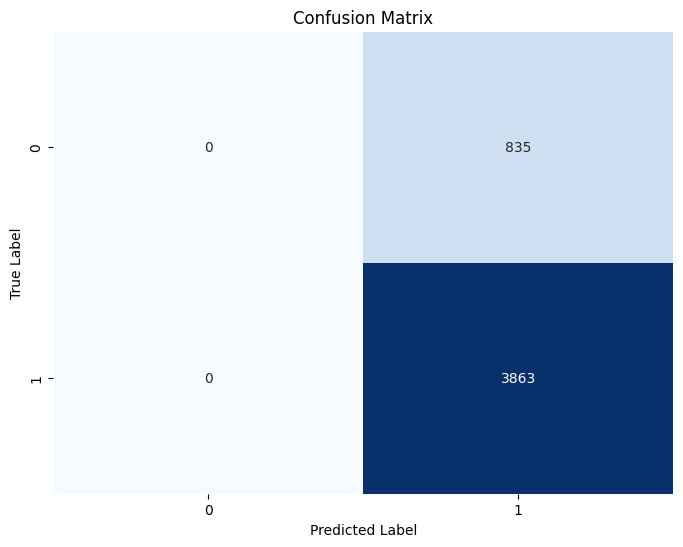

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('deep_rnn_confusion_matrix.png')
plt.show()

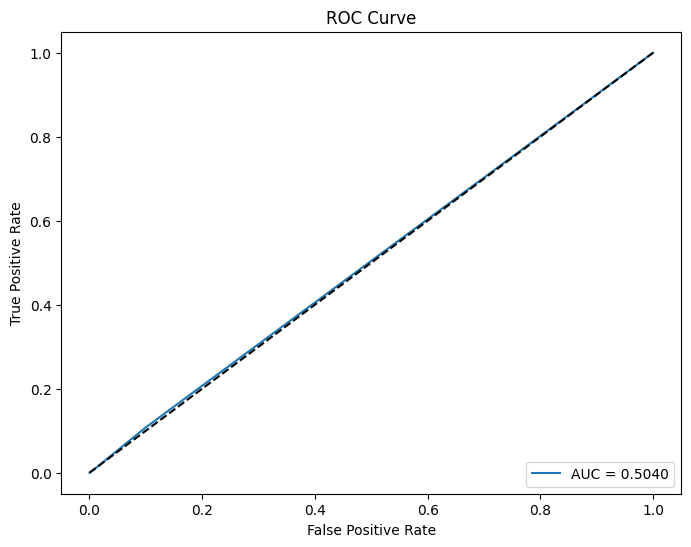

In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('deep_rnn_roc_curve.png')
plt.show()


In [27]:
# 9. Hyperparameter Tuning
print("\nStarting hyperparameter tuning...")

def model_builder(hp):
    return build_deep_rnn_model(hp)

tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,  # Increase for more thorough search
    executions_per_trial=1,
    directory='deep_rnn_hyperparameter_tuning',
    project_name='clothing_reviews_deep_rnn'
)

tuner.search(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Trial 10 Complete [00h 01m 46s]
val_accuracy: 0.8296966552734375

Best val_accuracy So Far: 0.901543378829956
Total elapsed time: 00h 17m 15s


In [28]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest hyperparameters found:")
print(f"RNN Type: {best_hps.get('rnn_type')}")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"RNN Units 1: {best_hps.get('rnn_units_1')}")
print(f"RNN Units 2: {best_hps.get('rnn_units_2')}")
print(f"RNN Units 3: {best_hps.get('rnn_units_3')}")
print(f"Dropout Rate 1: {best_hps.get('dropout_rate_1')}")
print(f"Dropout Rate 2: {best_hps.get('dropout_rate_2')}")
print(f"Dropout Rate 3: {best_hps.get('dropout_rate_3')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")



Best hyperparameters found:
RNN Type: gru
Embedding Dimension: 448
RNN Units 1: 256
RNN Units 2: 64
RNN Units 3: 64
Dropout Rate 1: 0.4
Dropout Rate 2: 0.2
Dropout Rate 3: 0.2
Dense Units: 64
Learning Rate: 0.005


In [29]:
# 10. Train the model with best hyperparameters
print("\nTraining final model with best hyperparameters...")
best_model = tuner.hypermodel.build(best_hps)



Training final model with best hyperparameters...


In [30]:
# Enhanced callbacks for final training
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,  # Increased patience for final model
    restore_best_weights=True,
    verbose=1
)

final_checkpoint = ModelCheckpoint(
    'final_deep_rnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

final_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

final_history = best_model.fit(
    X_train_pad, y_train,
    epochs=30,  # More epochs for final model with early stopping
    batch_size=64,
    validation_split=0.2,
    callbacks=[final_early_stopping, final_checkpoint, final_reduce_lr]
)


Epoch 1/30
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8072 - loss: 0.4865
Epoch 1: val_accuracy improved from -inf to 0.75652, saving model to final_deep_rnn_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8073 - loss: 0.4862 - val_accuracy: 0.7565 - val_loss: 0.4189 - learning_rate: 0.0050
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8554 - loss: 0.3140
Epoch 2: val_accuracy improved from 0.75652 to 0.89010, saving model to final_deep_rnn_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8554 - loss: 0.3139 - val_accuracy: 0.8901 - val_loss: 0.2709 - learning_rate: 0.0050
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9001 - loss: 0.2352
Epoch 3: val_accuracy did not improve from 0.89010
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9001 - loss: 0.2351 - val_accuracy: 0.8739 - val_loss: 0.2967 - learning_rate: 0.0050
Epoch 4/30
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9220 - loss: 0.1908
Epoch 4: val_accuracy did not improve from 0.89010
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9220 - loss: 0.1908 - val_accuracy: 0.8861 - val_loss: 0.2958 - learning_rate: 0.0050
Epoch 5/30
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9366 - loss: 0.1612
Epoch 5: val_accuracy did not improve from 0.89010

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9366 - loss: 0.1612 - va

235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9489 - loss: 0.1335 - val_accuracy: 0.8952 - val_loss: 0.3259 - learning_rate: 0.0025
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9627 - loss: 0.1075
Epoch 7: val_accuracy did not improve from 0.89516
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9627 - loss: 0.1074 - val_accuracy: 0.8920 - val_loss: 0.3908 - learning_rate: 0.0025
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9710 - loss: 0.0844
Epoch 8: val_accuracy did not improve from 0.89516

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9710 - loss: 0.0844 - val_accuracy: 0.8933 - val_loss: 0.4166 - learning_rate: 0.0025
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9781 - loss: 0.0726
Epoch 9: val_accuracy did not improve from 0.89516
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9781 - loss: 0.0726 - va

In [33]:
# 11. Final Evaluation
print("\nFinal evaluation...")
# Load the best model weights
best_model.load_weights('final_deep_rnn_model.h5')

# Evaluate on training set for the 90% requirement check
train_loss, train_accuracy = best_model.evaluate(X_train_pad, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred_prob_final = best_model.predict(X_test_pad)
y_pred_final = (y_pred_prob_final > 0.5).astype(int)




Final evaluation...
Training Accuracy: 0.9557
Test Accuracy: 0.8821
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [34]:
# Calculate final evaluation metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_pred_prob_final)

print("\nFinal Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"AUC-ROC: {final_auc:.4f}")



Final Model Performance:
Accuracy: 0.8821
Precision: 0.9261
Recall: 0.9309
F1 Score: 0.9285
AUC-ROC: 0.9068


In [35]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))




Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       835
           1       0.93      0.93      0.93      3863

    accuracy                           0.88      4698
   macro avg       0.80      0.79      0.80      4698
weighted avg       0.88      0.88      0.88      4698



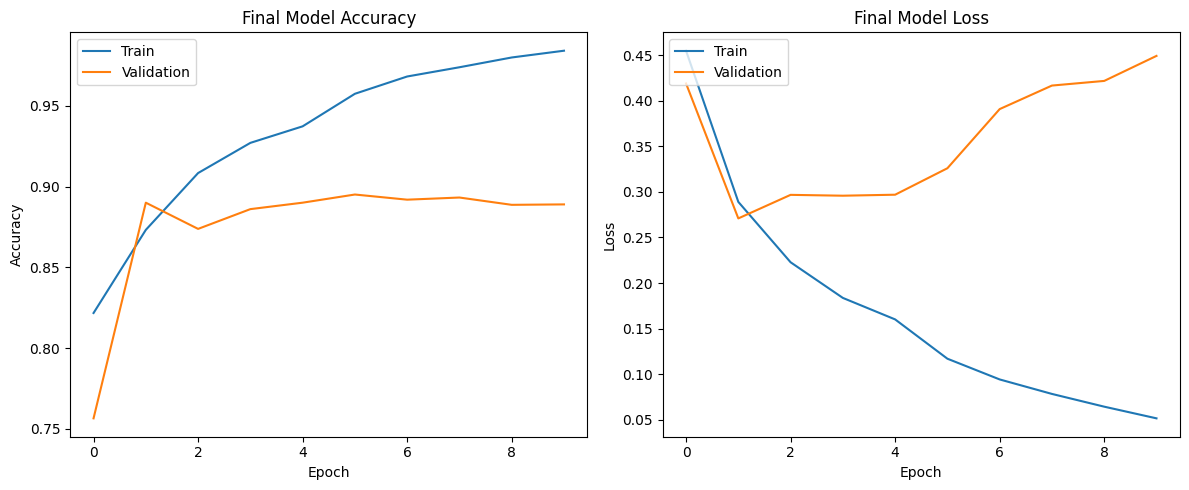

In [36]:
# 12. Final Visualizations for the best model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.title('Final Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('final_deep_rnn_training_metrics.png')
plt.show()

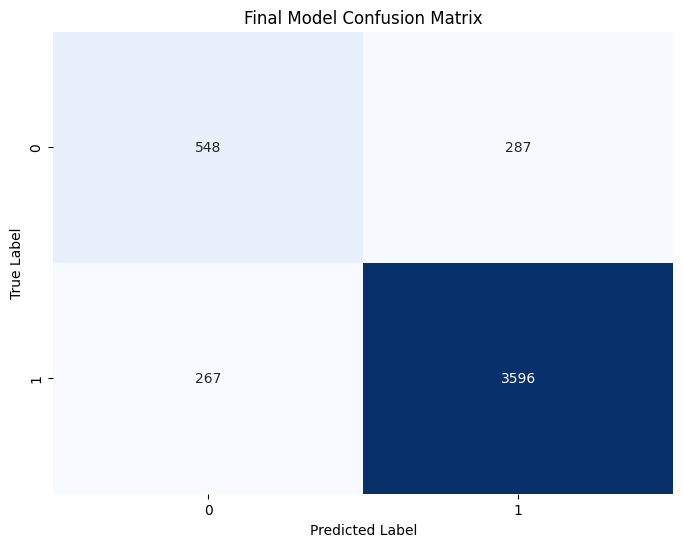

In [37]:
# Final Confusion Matrix
final_cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Final Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('final_deep_rnn_confusion_matrix.png')
plt.show()

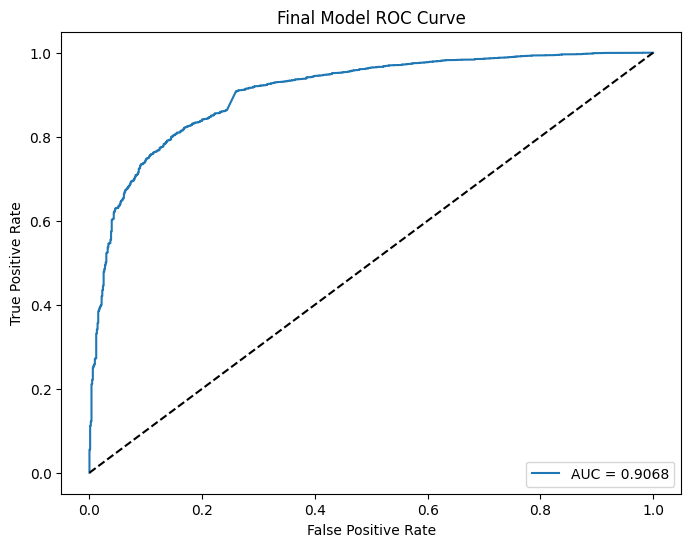

In [38]:
# Final ROC Curve
final_fpr, final_tpr, _ = roc_curve(y_test, y_pred_prob_final)
plt.figure(figsize=(8, 6))
plt.plot(final_fpr, final_tpr, label=f'AUC = {final_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Model ROC Curve')
plt.legend(loc='lower right')
plt.savefig('final_deep_rnn_roc_curve.png')
plt.show()